In [ ]:
import numpy as np
import torch
import pandas as pd
import os, sys, math
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from numpy.matlib import repmat
from scipy.io import loadmat
from functools import reduce
from operator import mul
import argparse
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import shutil
import ast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.matlib
import pdb
import scipy.stats
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%%capture
#%cd /content/drive/MyDrive/11785FinalProject
#!unzip LA.zip -d /root

In [ ]:
#Install other dependencies
#!pip install python_speech_features
#!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
#!pip install tqdm
#!pip install zipfile
#!pip install pytest-shutil
#!pip install multiprocessing

In [ ]:
#Save flac as wav files
import time
from tqdm import tqdm

def flac_to_wav(flacfiles, original_path, save_path):
  outfile = [f.replace('.flac', '.wav') for f in flacfiles]
  for i in tqdm(range(len(flacfiles))):
    cmd = 'sox ' + original_path + flacfiles[i] + " " + save_path + outfile[i]
    x = os.system(cmd)
    if(x != 0):
      print("failed")
      break

devpath = "/root/LA/ASVspoof2019_LA_dev/flac"
trainpath = "/root/LA/ASVspoof2019_LA_train/flac"
evalpath = "/root/LA/ASVspoof2019_LA_eval/flac"
savepath = "/root/LA2/ASVspoof2019_LA_dev/wav/"
devfiles = os.listdir(devpath)
trainfiles = os.listdir(trainpath)
evalfiles = os.listdir(evalpath)
flac_to_wav(trainfiles, original_path = trainpath + "/", save_path = "/content/drive/MyDrive/11785FinalProject/data/train/")
#flac_t_wav(trainfiles)

'import time\nfrom tqdm import tqdm\n\ndef flac_to_wav(flacfiles, original_path, save_path):\n  outfile = [f.replace(\'.flac\', \'.wav\') for f in flacfiles]\n  for i in tqdm(range(len(flacfiles))):\n    cmd = \'sox \' + original_path + flacfiles[i] + " " + save_path + outfile[i]\n    x = os.system(cmd)\n    if(x != 0):\n      print("failed")\n      break\n'

In [ ]:
#!zip -r '/content/drive/MyDrive/11785FinalProject/train_data.zip' '/content/drive/MyDrive/11785FinalProject/data/train/'

In [ ]:
# Dataset construction / dataloading
class MelBankDataset(Dataset):
	def __init__(self, data, names, keys, crop_size, dtype, gender_dict=None, colname = None):
		self.data = data
		self.keys = keys
		self.names = names
		self.crop_size = crop_size
		self.dtype = dtype
		self.unit = np.dtype(dtype).itemsize
		self.EXTEND = True
		self.gender_dict = gender_dict
		self.gender = {'m':0, 'f':1}
		self.colname = colname

	def __len__(self):
		return len(self.data)
	
	def _read_feat(self, index):
		#Currently it is (time, frequency)
		## IMP ##
		## Check the dimension here. Im not sure whether it would be (Time, Freq) or (Freq, Time). 
		## Following function usage may change depending on this shape. Confirm before continuing.
		cqcc = np.load(self.file_list[index])
		return cqcc
		
	def _extend_feat(self, feat, EXTEND):
		height, width = (200, 40) # cqcc
		if EXTEND:
			B = repmat(feat,int(math.ceil(height/(feat.shape[0]))), 1)
			C = B.reshape(-1,width)
			D = C[:height,:]
		if not EXTEND: D = feat
		## normalizing ##
		frame_n = 300
		for s_pt in range(0, D.shape[0], frame_n):
			e_pt = min(s_pt+frame_n, D.shape[0])
			D[s_pt:e_pt, :] = D[s_pt:e_pt, :] - D[s_pt:e_pt, :].mean(axis=0)
			D[s_pt:e_pt, :] = D[s_pt:e_pt, :] / (D[s_pt:e_pt, :].std(axis=0)+np.finfo(np.float16).eps)
		D=D.astype('float32').transpose()[np.newaxis, ...]
		return D

	def __getitem__(self, index):
		basename = self.names[index][0]
		labels = self.keys[self.keys[self.colname]== basename]
		gend_label = self.gender_dict[labels.iloc[0].iloc[0]]
		if(gend_label == "u-m"):
			gend_label = "m"
		gender = self.gender[gend_label]
		device = 0 if labels.iloc[0].iloc[3] == "-" else 1
		data = self.data[index][0]
		data = self._extend_feat(data, self.EXTEND)
		return (basename, data, gender, device)

In [ ]:
train_names = np.load("/content/drive/MyDrive/11785FinalProject/data/train_names.npy")
train_data = np.load("/content/drive/MyDrive/11785FinalProject/data/train.npy", allow_pickle = True)
dev_names = np.load("/content/drive/MyDrive/11785FinalProject/data/dev_names.npy")
dev_data = np.load("/content/drive/MyDrive/11785FinalProject/data/dev.npy", allow_pickle = True)

In [ ]:
#Model
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Unflatten(nn.Module):
    def __init__(self, channel, height, width):
        super(Unflatten, self).__init__()
        self.channel = channel
        self.height = height
        self.width = width
    def forward(self, input):
        return input.view(input.size(0), self.channel, self.height, self.width)

class ConvVAE(nn.Module):
    def __init__(self, latent_size):
        super(ConvVAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(3,3), stride=(1,2), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(256, 128, kernel_size=(5,5), stride=(2,2), padding=(2,2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(128,128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(128,64, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.ReLU(),
            Flatten(),
            nn.Linear(64000, self.latent_size * 2),
            nn.ReLU()
        )
        # hidden => mu
        self.fc1 = nn.Linear( self.latent_size * 2, self.latent_size)
        # hidden => logvar
        self.fc2 = nn.Linear( self.latent_size * 2, self.latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size+1,  self.latent_size * 2),
            nn.ReLU(),
            nn.Linear( self.latent_size * 2, 64000),
            nn.ReLU(),
            Unflatten(64,  20 , 50),
            nn.ReLU(),
            nn.ConvTranspose2d(64,128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.ReLU(),
            nn.ConvTranspose2d(128,128, kernel_size = (3,3), stride = (1,1), padding = (1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=(5,5), stride=(2,2), padding=(2,2)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=(3,4), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 1, kernel_size=(4,4), stride=(1,2), padding= (1,1)),
            nn.Sigmoid()
        )
    def encode(self, x, gender= None):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h) #logvar not actually log 
        return mu, logvar

    def decode(self, z):
        z = self.decoder(z)
        return z

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def reparameterize_eval(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x, gender, do_cf = True):
        #pdb.set_trace()
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar) #(Batch size, latentsize)
        z1 = torch.cat((z, gender[:,None]), dim = 1) #(Batch size, latentsize + 1)
        cf_res =0
        if(do_cf): 
          counterfact = torch.cat((z, torch.logical_not(gender)[:,None]), dim = 1) #(batchsize, latentsize+1)
          cf_res = self.decode(counterfact)
        return self.decode(z1), cf_res, mu, logvar

In [ ]:
keys_t = pd.read_csv('/content/drive/MyDrive/11785FinalProject/data/ASVspoof2019.LA.cm.train.trn.txt', sep=" ")#=["name", "data","None", "Device", "Bona"])
keys_d = pd.read_csv('/content/drive/MyDrive/11785FinalProject/data/ASVspoof2019.LA.cm.dev.trl.txt', sep=" ")#=["name", "data","None", "Device", "Bona"])
keys_t = keys_t.rename(columns={'LA_0079': 'Speaker', 'LA_T_1138215': 'Filename', '-': "-", "-.1":"Device", "bonafide": "bonafide"})
keys_d = keys_d.rename(columns={'LA_0069': 'Speaker', 'LA_D_1047731': 'Filename', '-': "-", "-.1":"Device", "bonafide": "bonafide"})
keys = keys_t.append(keys_d, ignore_index=True)

def filter_one(audio_data, names, keys, colname):
  rows = keys["bonafide"] == "bonafide"
  bona_files = []
  bona_names = []
  indices = keys.index
  bona_ind = indices[rows]
  for row in bona_ind:
    d = keys.iloc[row]
    filename= d.loc[colname] 
    where = np.where(names == filename)
    bona_files.append(audio_data[where])
    bona_names.append(names[where])

  rows2 = keys["bonafide"] != "bonafide"
  fake_ind = indices[rows2]
  fake_files = []
  fake_names = []
  for row in fake_ind:
    d = keys.iloc[row]
    filename= d.loc[colname]
    where = np.where(names == filename)
    fake_files.append(audio_data[where])
    fake_names.append(names[where])
  return bona_files, bona_names, fake_files, fake_names
 
data = np.concatenate((train_data, dev_data), axis = 0)
names = np.concatenate((train_names, dev_names), axis = 0)

b_files, b_names, f_files, f_names = filter_one(data, names, keys, colname = "Filename")


In [ ]:
#Train segment
cuda = torch.cuda.is_available()
if cuda:
    print('cuda available')

device = torch.device("cuda" if cuda else "cpu")

def pvalue(predicted, mean, var):
    z = (predicted - mean) / var
    pval = scipy.stats.norm.sf(np.abs(z))
    #If pval is less than 1-alpha, predict False. If pval >= 1-alpha, predict True (it is from the distribution)
    return pval

def loss_function(recon_x, x, mu, logvar):
    # reconstruction loss
    rshape = recon_x.shape
    xshape = x.shape
    x = torch.softmax(x, 3)
    logvar = torch.exp(logvar)
    BCE = F.binary_cross_entropy(recon_x.view(-1, rshape[0] * rshape[1]*rshape[2]*rshape[3]), (x.view(-1, xshape[0]*xshape[1]*xshape[2]*xshape[3])), reduction = "mean")
    RMSE = torch.sqrt(F.binary_cross_entropy(recon_x.view(rshape[0], rshape[1]*rshape[2]*rshape[3]), x.view(xshape[0], xshape[2]*xshape[1]*xshape[3]), reduction = "none").mean(dim = 1))
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, RMSE.detach().cpu().numpy()

### Training #####
def train(epoch, model, train_loader, optimizer, args, device):
    mse = nn.MSELoss()
    model.train()
    train_loss = 0
    rmse_real, rmse_fake = [], []
    gender0mse, gender1mse = 0,0
    num_zeros, num_ones = 1,1
    for batch_idx, (basename, data, gender, device_) in enumerate(train_loader):
        data,gender = data.to(device), gender.to(device)
        optimizer.zero_grad()
        recon_batch, counter_factual, mu, logvar = model(data, gender)
        zeros = (gender == 0)#.nonzero().detach().numpy()
        ones = (gender == 1)#.nonzero().detach().numpy()
        num_zeros += len(zeros)
        num_ones += len(ones)
        loss, rmse = loss_function(recon_batch, data, mu, logvar)
        rmse_real.extend(rmse)
        nan_count = torch.sum(torch.isnan(recon_batch))
        if(nan_count.item() != 0):
          pdb.set_trace()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader.dataset)
    gender0mse /= num_zeros
    gender1mse /= num_ones
    torch.cuda.empty_cache()
    del gender
    del data
    del recon_batch
    del mu
    del logvar
    del loss
    del rmse
    del zeros
    del ones
    return train_loss, np.asarray(rmse_real), gender0mse, gender1mse

### Validating ####
def test(epoch, model, test_loader, args, rmse_real, device, threshold):
    model.eval()
    test_loss = 0
    mse = nn.MSELoss()
    percentile_val = np.percentile(rmse_real, threshold)
    print("percentile info: ", "threshold: ", round(percentile_val,5), "mean: ", round(np.mean(rmse_real),5))
    mean, var = np.mean(rmse_real), np.std(rmse_real)
    test_acc = 0
    test_auc = 0
    test_f1 = 0
    num_zeros, num_ones = 1,1
    gender0mse, gender1mse = 0,0
    total = 0
    rmse_0, rmse_1 = [],[]
    rmse_male, rmse_female = [], []
    stop_point = int(len(test_loader) * 0.7)
    rmse_fake_f, rmse_fake_m = [],[]
    with torch.no_grad():
        for batch_idx, (basename, data, gender, device_) in enumerate(test_loader):
            data,gender1 = data.to(device), gender.to(device)
            recon_batch,counter_factual, mu, logvar = model(data, gender1, True)
            loss, rmse = loss_function(recon_batch, data, mu, logvar)
            
            zeros = (gender == 0)#.nonzero().detach().numpy()
            ones = (gender == 1)#.nonzero().detach().numpy()
            gender0mse += mse(recon_batch[zeros], counter_factual[zeros]).item()
            gender1mse += mse(recon_batch[ones], counter_factual[ones]).item()
            num_zeros += len(zeros)
            num_ones += len(ones)

            zeros_g = (gender == 0).nonzero().detach().numpy()
            ones_g = (gender == 1).nonzero().detach().numpy()
            rmse_male.extend(rmse[zeros_g].tolist())
            rmse_female.extend(rmse[ones_g].tolist())

            zeros_d = (device_ == 0).nonzero().detach().numpy()
            ones_d = (device_ == 1).nonzero().detach().numpy()
            rmse_0.extend(rmse[zeros_d].tolist())
            rmse_1.extend(rmse[ones_d].tolist())

            female_fake = np.intersect1d(ones_d, ones_g)
            male_fake = np.intersect1d(ones_d, zeros_g)
            rmse_fake_f.extend(rmse[female_fake])
            rmse_fake_m.extend(rmse[male_fake])
            
            pred = (torch.from_numpy(rmse) > percentile_val).float() # > for training on bona
            acc = (pred == device_).float().sum()
            f1_score = metrics.f1_score(device_, pred)
            test_loss += loss.item()
            test_acc += acc.item()
            #test_auc += auc
            test_f1 += f1_score
            total += data.shape[0]
    test_loss /= total
    test_acc /= total
    test_auc /= total
    test_f1 /= len(test_loader)
    gender0mse /= num_zeros
    gender1mse /= num_zeros
    del data
    del recon_batch
    del mu
    del logvar
    del rmse
    return test_loss, test_acc, test_auc, test_f1, rmse_1, rmse_0, gender0mse, gender1mse, rmse_male, rmse_female, rmse_fake_m, rmse_fake_f

def valid(epoch, model, test_loader, args, rmse_real, device, threshold):
    model.eval()
    test_loss = 0
    mse = nn.MSELoss()
    #threshold = 90 #80 #70 #80 #90
    percentile_val = np.percentile(rmse_real, threshold)
    mean, var = np.mean(rmse_real), np.std(rmse_real)
    test_acc = 0
    test_auc = 0
    test_f1 = 0
    num_zeros, num_ones = 1,1
    gender0mse, gender1mse = 0,0
    total = 0
    rmse_0, rmse_1 = [],[]
    rmse_male, rmse_female = [], []
    stop_point = int(len(test_loader) * 0.7)
    with torch.no_grad():
        for batch_idx, (basename, data, gender, device_) in enumerate(test_loader):
            data,gender1 = data.to(device), gender.to(device)
            recon_batch,counter_factual, mu, logvar = model(data, gender1, True)
            loss, rmse = loss_function(recon_batch, data, mu, logvar)
            
            zeros = (gender == 0)#.nonzero().detach().numpy()
            ones = (gender == 1)#.nonzero().detach().numpy()
            gender0mse += mse(recon_batch[zeros], counter_factual[zeros]).item()
            gender1mse += mse(recon_batch[ones], counter_factual[ones]).item()
            num_zeros += len(zeros)
            num_ones += len(ones)
            zeros = (gender == 0).nonzero().detach().numpy()
            ones = (gender == 1).nonzero().detach().numpy()
            rmse_male.extend(rmse[zeros].tolist())
            rmse_female.extend(rmse[ones].tolist())


            zeros = (device_ == 0).nonzero().detach().numpy()
            ones = (device_ == 1).nonzero().detach().numpy()
            rmse_0.extend(rmse[zeros].tolist())
            rmse_1.extend(rmse[ones].tolist())

            
            pred = (torch.from_numpy(rmse) > percentile_val).float() # > for training on bona
            acc = (pred == device_).float().sum()
            test_loss += loss.item()
            test_acc += acc.item()
            total += data.shape[0]
    test_loss /= total
    test_acc /= total
    test_auc /= total
    test_f1 /= len(test_loader)
    gender0mse /= num_zeros
    gender1mse /= num_zeros
    torch.cuda.empty_cache()
    del data
    del recon_batch
    del mu
    del logvar
    del rmse
    return test_loss, test_acc, test_auc, test_f1, rmse_1, rmse_0, gender0mse, gender1mse, rmse_male, rmse_female

cuda available


percentile info:  threshold:  0.28607 mean:  0.42285
test rmse info: 0std: 0.00084, 0mean: 0.19228, 1std: 0.00113, 1mean: 0.192899, mean_diff: 0.00062
Epoch [1/40] loss: 46.11501 val_loss: 1.16106 gender0 mse: 0.19198 gender1mse: 0.19342 threshold: 65  f1: 0.0000000   train_acc:1.00000   test_acc: 0.0222241
0.19199072 0.19343758
****************************** Learning Rate:  2e-05 ******************************


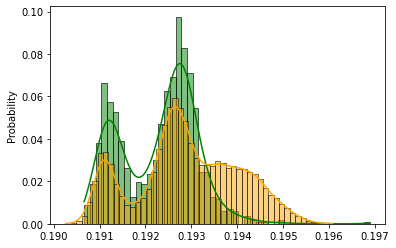

percentile info:  threshold:  0.17914 mean:  0.17879
test rmse info: 0std: 0.00064, 0mean: 0.182546, 1std: 0.00128, 1mean: 0.183463, mean_diff: 0.00092
Epoch [2/40] loss: 0.92931 val_loss: 0.89194 gender0 mse: 0.18325 gender1mse: 0.18356 threshold: 65  f1: 0.9885880   train_acc:0.00171   test_acc: 0.9777759
0.18326443 0.18358035
****************************** Learning Rate:  2e-05 ******************************


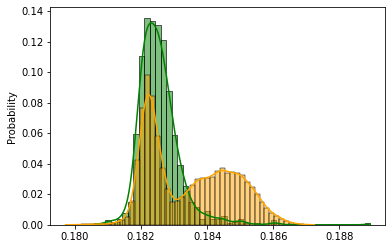

percentile info:  threshold:  0.17767 mean:  0.1775
test rmse info: 0std: 0.00089, 0mean: 0.179924, 1std: 0.00153, 1mean: 0.181004, mean_diff: 0.00108
Epoch [3/40] loss: 0.75921 val_loss: 0.69057 gender0 mse: 0.18116 gender1mse: 0.18087 threshold: 65  f1: 0.9869820   train_acc:0.01683   test_acc: 0.9746970
0.1811852 0.18089579
****************************** Learning Rate:  2e-05 ******************************


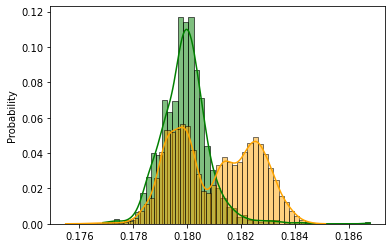

percentile info:  threshold:  0.17696 mean:  0.17683
test rmse info: 0std: 0.00108, 0mean: 0.179027, 1std: 0.00172, 1mean: 0.180215, mean_diff: 0.00119
Epoch [4/40] loss: 0.63148 val_loss: 0.55312 gender0 mse: 0.18054 gender1mse: 0.17998 threshold: 65  f1: 0.9838047   train_acc:0.06657   test_acc: 0.9686477
0.18055852 0.18001094
****************************** Learning Rate:  2e-05 ******************************


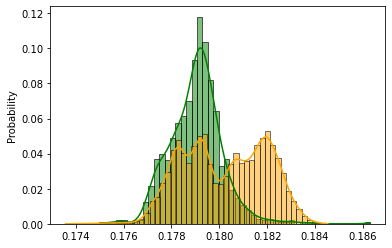

percentile info:  threshold:  0.1765 mean:  0.17637
test rmse info: 0std: 0.00127, 0mean: 0.17858, 1std: 0.00187, 1mean: 0.179847, mean_diff: 0.00127
Epoch [5/40] loss: 0.53234 val_loss: 0.46624 gender0 mse: 0.18029 gender1mse: 0.17954 threshold: 65  f1: 0.9722534   train_acc:0.09754   test_acc: 0.9468572
0.18031475 0.1795688
****************************** Learning Rate:  2e-05 ******************************


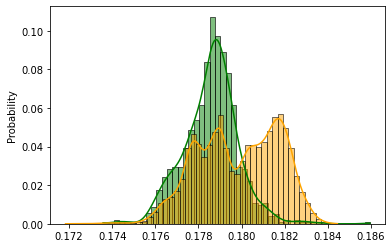

percentile info:  threshold:  0.17615 mean:  0.17602
test rmse info: 0std: 0.00141, 0mean: 0.177986, 1std: 0.00206, 1mean: 0.179375, mean_diff: 0.00139
Epoch [6/40] loss: 0.45218 val_loss: 0.37447 gender0 mse: 0.17991 gender1mse: 0.17901 threshold: 65  f1: 0.9597446   train_acc:0.16874   test_acc: 0.9239826
0.17993137 0.17904405
****************************** Learning Rate:  2e-05 ******************************


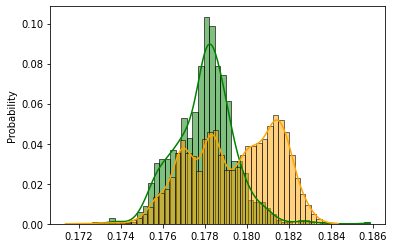

percentile info:  threshold:  0.17585 mean:  0.17575
test rmse info: 0std: 0.00171, 0mean: 0.177768, 1std: 0.00236, 1mean: 0.179317, mean_diff: 0.00155
Epoch [7/40] loss: 0.37974 val_loss: 0.33938 gender0 mse: 0.17991 gender1mse: 0.17891 threshold: 65  f1: 0.9495004   train_acc:0.18971   test_acc: 0.9055745
0.17993513 0.1789497
****************************** Learning Rate:  2e-05 ******************************


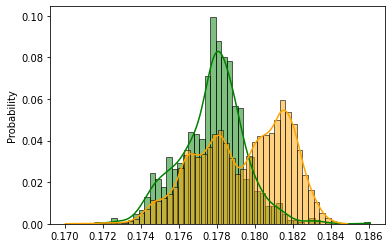

percentile info:  threshold:  0.17568 mean:  0.17554
test rmse info: 0std: 0.00186, 0mean: 0.177543, 1std: 0.00249, 1mean: 0.179164, mean_diff: 0.00162
Epoch [8/40] loss: 0.32675 val_loss: 0.27598 gender0 mse: 0.17976 gender1mse: 0.17875 threshold: 65  f1: 0.9444069   train_acc:0.19824   test_acc: 0.8964680
0.17978422 0.17879501
****************************** Learning Rate:  2e-05 ******************************


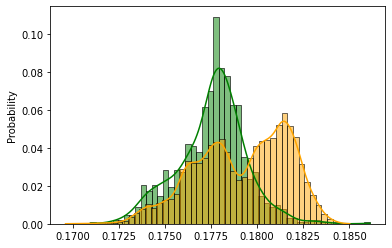

percentile info:  threshold:  0.17549 mean:  0.17535
test rmse info: 0std: 0.00218, 0mean: 0.177735, 1std: 0.00274, 1mean: 0.179468, mean_diff: 0.00173
Epoch [9/40] loss: 0.28393 val_loss: 0.24467 gender0 mse: 0.18016 gender1mse: 0.17899 threshold: 65  f1: 0.9464592   train_acc:0.18142   test_acc: 0.9003057
0.18019289 0.17903799
****************************** Learning Rate:  2e-05 ******************************


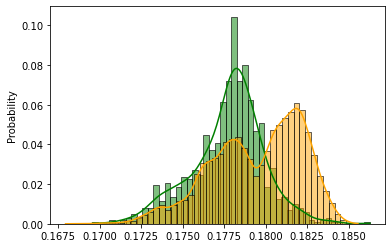

percentile info:  threshold:  0.17538 mean:  0.1752
test rmse info: 0std: 0.00252, 0mean: 0.177973, 1std: 0.003, 1mean: 0.1798, mean_diff: 0.00183
Epoch [10/40] loss: 0.24542 val_loss: 0.20331 gender0 mse: 0.18056 gender1mse: 0.17929 threshold: 65  f1: 0.9470248   train_acc:0.17630   test_acc: 0.9011730
0.18059029 0.17933156
****************************** Learning Rate:  2e-05 ******************************


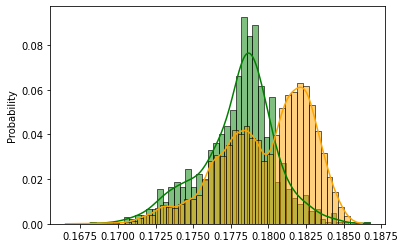

percentile info:  threshold:  0.17526 mean:  0.17509
test rmse info: 0std: 0.00286, 0mean: 0.177882, 1std: 0.00336, 1mean: 0.179912, mean_diff: 0.00203
Epoch [11/40] loss: 0.21239 val_loss: 0.17184 gender0 mse: 0.18062 gender1mse: 0.17942 threshold: 65  f1: 0.9427395   train_acc:0.19507   test_acc: 0.8937794
0.18065143 0.17947334
****************************** Learning Rate:  2e-05 ******************************


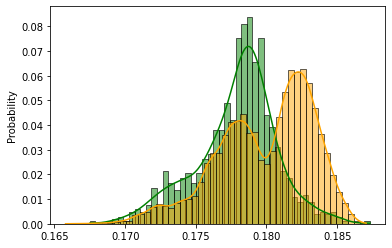

percentile info:  threshold:  0.17517 mean:  0.17498
test rmse info: 0std: 0.00317, 0mean: 0.17808, 1std: 0.00365, 1mean: 0.180254, mean_diff: 0.00217
Epoch [12/40] loss: 0.18655 val_loss: 0.15087 gender0 mse: 0.18095 gender1mse: 0.17976 threshold: 65  f1: 0.9440187   train_acc:0.18678   test_acc: 0.8959476
0.18099175 0.1798158
****************************** Learning Rate:  2e-05 ******************************


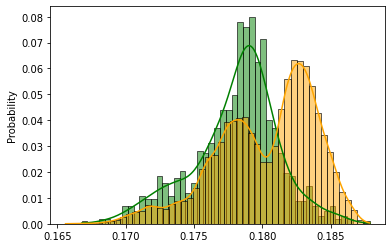

percentile info:  threshold:  0.1751 mean:  0.17489
test rmse info: 0std: 0.00358, 0mean: 0.178396, 1std: 0.004, 1mean: 0.180727, mean_diff: 0.00233
Epoch [13/40] loss: 0.16552 val_loss: 0.13341 gender0 mse: 0.18134 gender1mse: 0.18028 threshold: 65  f1: 0.9455353   train_acc:0.17654   test_acc: 0.8986579
0.18138435 0.18033639
****************************** Learning Rate:  2e-05 ******************************


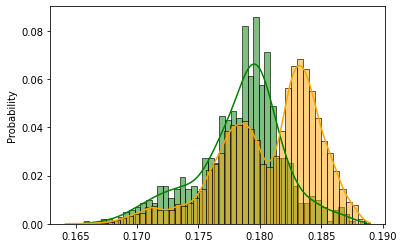

percentile info:  threshold:  0.17503 mean:  0.17482
test rmse info: 0std: 0.00381, 0mean: 0.17882, 1std: 0.0042, 1mean: 0.181249, mean_diff: 0.00243
Epoch [14/40] loss: 0.14778 val_loss: 0.12619 gender0 mse: 0.18191 gender1mse: 0.18077 threshold: 65  f1: 0.9492079   train_acc:0.16191   test_acc: 0.9049891
0.18195532 0.1808299
****************************** Learning Rate:  2e-05 ******************************


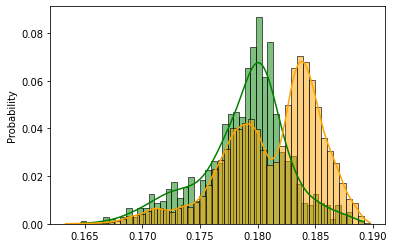

percentile info:  threshold:  0.17497 mean:  0.17476
test rmse info: 0std: 0.0042, 0mean: 0.178933, 1std: 0.0046, 1mean: 0.181559, mean_diff: 0.00263
Epoch [15/40] loss: 0.13191 val_loss: 0.11245 gender0 mse: 0.18200 gender1mse: 0.18121 threshold: 65  f1: 0.9469260   train_acc:0.17435   test_acc: 0.9011080
0.18204455 0.18127151
****************************** Learning Rate:  2e-05 ******************************


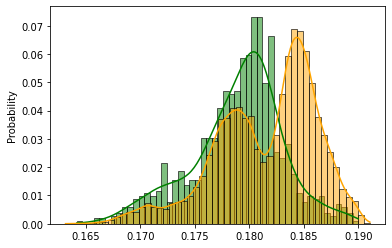

percentile info:  threshold:  0.17492 mean:  0.17471
test rmse info: 0std: 0.00438, 0mean: 0.179454, 1std: 0.00472, 1mean: 0.182112, mean_diff: 0.00266
Epoch [16/40] loss: 0.11958 val_loss: 0.10347 gender0 mse: 0.18269 gender1mse: 0.18168 threshold: 65  f1: 0.9508651   train_acc:0.15265   test_acc: 0.9080029
0.18273272 0.18174326
****************************** Learning Rate:  2e-05 ******************************


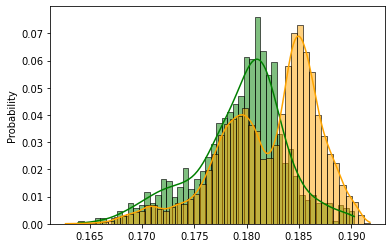

percentile info:  threshold:  0.1749 mean:  0.17468
test rmse info: 0std: 0.00457, 0mean: 0.179796, 1std: 0.00488, 1mean: 0.182525, mean_diff: 0.00273
Epoch [17/40] loss: 0.10773 val_loss: 0.09079 gender0 mse: 0.18311 gender1mse: 0.18208 threshold: 65  f1: 0.9525605   train_acc:0.14484   test_acc: 0.9110600
0.18315482 0.1821515
****************************** Learning Rate:  2e-05 ******************************


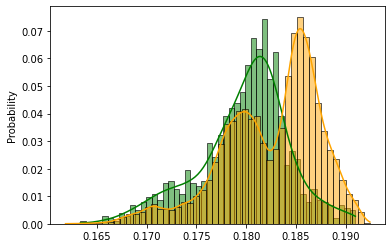

percentile info:  threshold:  0.17487 mean:  0.17465
test rmse info: 0std: 0.00474, 0mean: 0.179577, 1std: 0.00511, 1mean: 0.182454, mean_diff: 0.00288
Epoch [18/40] loss: 0.09766 val_loss: 0.08168 gender0 mse: 0.18278 gender1mse: 0.18216 threshold: 65  f1: 0.9495538   train_acc:0.16167   test_acc: 0.9057046
0.18283086 0.18223077
****************************** Learning Rate:  2e-05 ******************************


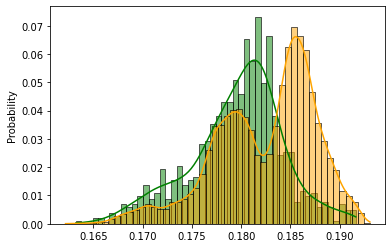

percentile info:  threshold:  0.17483 mean:  0.17461
test rmse info: 0std: 0.00496, 0mean: 0.179744, 1std: 0.00538, 1mean: 0.182784, mean_diff: 0.00304
Epoch [19/40] loss: 0.08919 val_loss: 0.07451 gender0 mse: 0.18301 gender1mse: 0.18254 threshold: 65  f1: 0.9493408   train_acc:0.16508   test_acc: 0.9052709
0.18306363 0.18261859
****************************** Learning Rate:  2e-05 ******************************


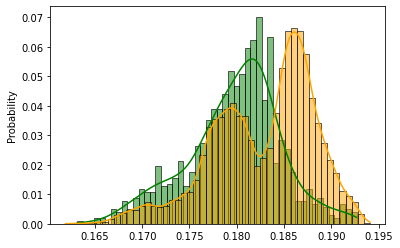

percentile info:  threshold:  0.17481 mean:  0.1746
test rmse info: 0std: 0.00495, 0mean: 0.179518, 1std: 0.0054, 1mean: 0.182578, mean_diff: 0.00306
Epoch [20/40] loss: 0.08132 val_loss: 0.06685 gender0 mse: 0.18275 gender1mse: 0.18236 threshold: 65  f1: 0.9472930   train_acc:0.17679   test_acc: 0.9016717
0.18281095 0.18243968
****************************** Learning Rate:  2e-05 ******************************


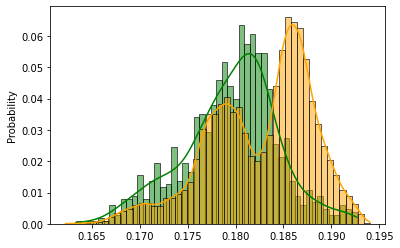

percentile info:  threshold:  0.17481 mean:  0.17459
test rmse info: 0std: 0.00505, 0mean: 0.18013, 1std: 0.00542, 1mean: 0.183151, mean_diff: 0.00302
Epoch [21/40] loss: 0.07512 val_loss: 0.07001 gender0 mse: 0.18370 gender1mse: 0.18272 threshold: 65  f1: 0.9514617   train_acc:0.14752   test_acc: 0.9090870
0.1837523 0.18279451
****************************** Learning Rate:  2e-05 ******************************


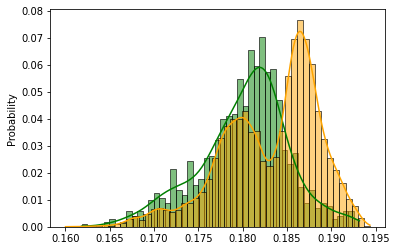

percentile info:  threshold:  0.17479 mean:  0.17457
test rmse info: 0std: 0.00506, 0mean: 0.179483, 1std: 0.00558, 1mean: 0.182666, mean_diff: 0.00318
Epoch [22/40] loss: 0.06920 val_loss: 0.06548 gender0 mse: 0.18282 gender1mse: 0.18246 threshold: 65  f1: 0.9462685   train_acc:0.17922   test_acc: 0.8998287
0.18287861 0.18253964
****************************** Learning Rate:  2e-05 ******************************


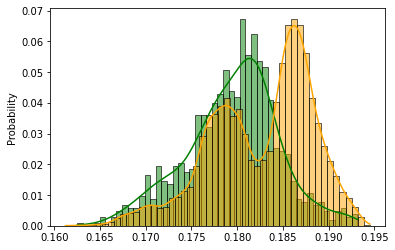

percentile info:  threshold:  0.17476 mean:  0.17456
test rmse info: 0std: 0.00508, 0mean: 0.179282, 1std: 0.00567, 1mean: 0.182541, mean_diff: 0.00326
Epoch [23/40] loss: 0.06370 val_loss: 0.05942 gender0 mse: 0.18265 gender1mse: 0.18236 threshold: 65  f1: 0.9440090   train_acc:0.18922   test_acc: 0.8959259
0.18271613 0.18243624
****************************** Learning Rate:  2e-05 ******************************


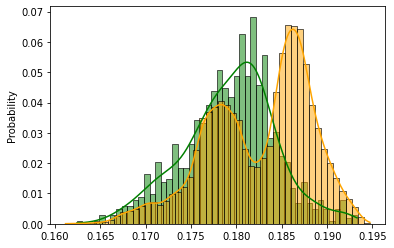

percentile info:  threshold:  0.17477 mean:  0.17455
test rmse info: 0std: 0.00512, 0mean: 0.180178, 1std: 0.00563, 1mean: 0.183356, mean_diff: 0.00318
Epoch [24/40] loss: 0.05891 val_loss: 0.06271 gender0 mse: 0.18400 gender1mse: 0.18286 threshold: 65  f1: 0.9516118   train_acc:0.14631   test_acc: 0.9094989
0.18405703 0.18293947
****************************** Learning Rate:  2e-05 ******************************


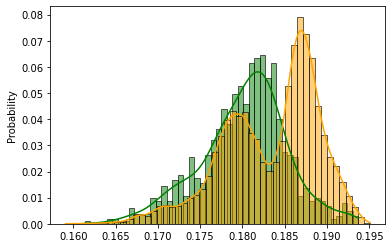

percentile info:  threshold:  0.17477 mean:  0.17455
test rmse info: 0std: 0.00507, 0mean: 0.179156, 1std: 0.00574, 1mean: 0.18249, mean_diff: 0.00333
Epoch [25/40] loss: 0.05479 val_loss: 0.05103 gender0 mse: 0.18268 gender1mse: 0.18226 threshold: 65  f1: 0.9419392   train_acc:0.19629   test_acc: 0.8922833
0.18274416 0.18233955
****************************** Learning Rate:  2e-05 ******************************


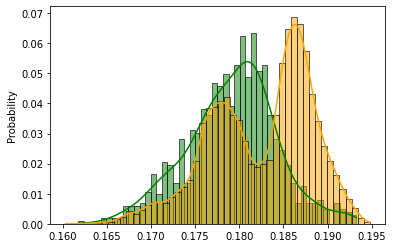

percentile info:  threshold:  0.17477 mean:  0.17454
test rmse info: 0std: 0.00488, 0mean: 0.178862, 1std: 0.00558, 1mean: 0.182134, mean_diff: 0.00327
Epoch [26/40] loss: 0.05064 val_loss: 0.05244 gender0 mse: 0.18243 gender1mse: 0.18184 threshold: 65  f1: 0.9402122   train_acc:0.19971   test_acc: 0.8893346
0.18249685 0.181918
****************************** Learning Rate:  2e-05 ******************************


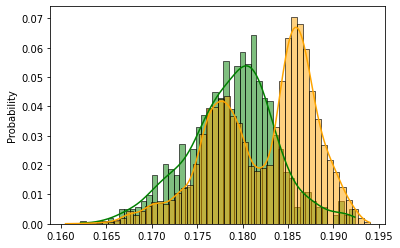

percentile info:  threshold:  0.17474 mean:  0.17453
test rmse info: 0std: 0.00503, 0mean: 0.178923, 1std: 0.00576, 1mean: 0.182294, mean_diff: 0.00337
Epoch [27/40] loss: 0.04723 val_loss: 0.04913 gender0 mse: 0.18251 gender1mse: 0.18205 threshold: 65  f1: 0.9400528   train_acc:0.20117   test_acc: 0.8890310
0.18257214 0.18212928
****************************** Learning Rate:  2e-05 ******************************


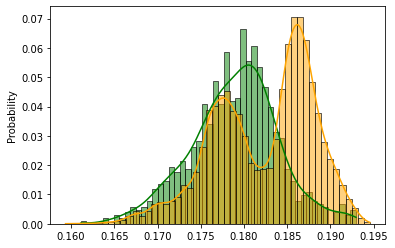

percentile info:  threshold:  0.17473 mean:  0.17452
test rmse info: 0std: 0.00495, 0mean: 0.178699, 1std: 0.00576, 1mean: 0.182107, mean_diff: 0.00341
Epoch [28/40] loss: 0.04400 val_loss: 0.04941 gender0 mse: 0.18233 gender1mse: 0.18185 threshold: 65  f1: 0.9370588   train_acc:0.21336   test_acc: 0.8837840
0.18240061 0.18193233
****************************** Learning Rate:  2e-05 ******************************


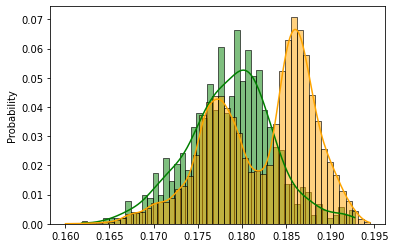

percentile info:  threshold:  0.17472 mean:  0.17452
test rmse info: 0std: 0.00489, 0mean: 0.178272, 1std: 0.0058, 1mean: 0.181744, mean_diff: 0.00347
Epoch [29/40] loss: 0.04075 val_loss: 0.04047 gender0 mse: 0.18184 gender1mse: 0.18156 threshold: 65  f1: 0.9268875   train_acc:0.24799   test_acc: 0.8663732
0.18190672 0.18164691
****************************** Learning Rate:  2e-05 ******************************


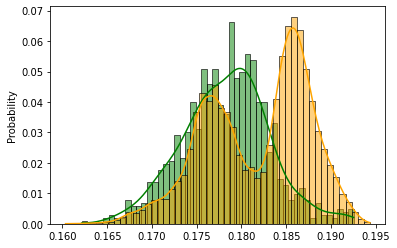

percentile info:  threshold:  0.17472 mean:  0.17452
test rmse info: 0std: 0.00491, 0mean: 0.178525, 1std: 0.00579, 1mean: 0.181969, mean_diff: 0.00344
Epoch [30/40] loss: 0.03807 val_loss: 0.04840 gender0 mse: 0.18221 gender1mse: 0.18171 threshold: 65  f1: 0.9324451   train_acc:0.22824   test_acc: 0.8758917
0.18227512 0.18178768
****************************** Learning Rate:  2e-05 ******************************


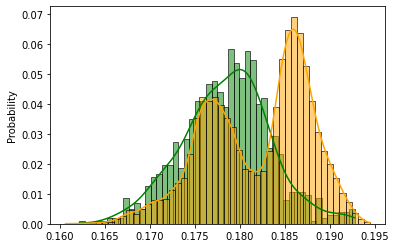

percentile info:  threshold:  0.17471 mean:  0.17452
test rmse info: 0std: 0.00486, 0mean: 0.178146, 1std: 0.00579, 1mean: 0.181621, mean_diff: 0.00348
Epoch [31/40] loss: 0.03572 val_loss: 0.04100 gender0 mse: 0.18171 gender1mse: 0.18144 threshold: 65  f1: 0.9243394   train_acc:0.25165   test_acc: 0.8620368
0.18178162 0.18152586
****************************** Learning Rate:  2e-05 ******************************


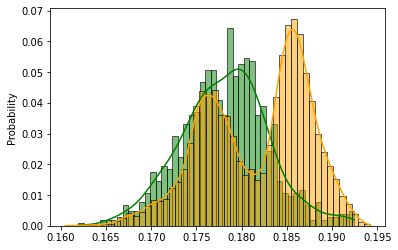

percentile info:  threshold:  0.17472 mean:  0.17452


In [ ]:
def save_checkpoint(state, is_best, outdir):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    checkpoint_file = os.path.join(outdir, 'checkpoint.pth')
    best_file = os.path.join(outdir, 'model_best.pth')
    torch.save(state, checkpoint_file)
    if is_best:
        shutil.copyfile(checkpoint_file, best_file)



def main(train_data, train_names, dev_data, dev_names):
    parser = argparse.ArgumentParser(description='Explainable VAE MNIST Example')
    #parser.add_argument('--result_dir', type=str, default='/content/drive/MyDrive/11785FinalProject/results/', metavar='DIR',
    #                    help='output directory')
    parser.add_argument('--ckpt_dir', type=str, default='/content/drive/MyDrive/11785FinalProject/results/ckpt.pt', metavar='DIR',
                        help='ckpt directory')
    parser.add_argument('--batch_size', type=int, default=32, metavar='N',
                        help='input batch size for training (default: 128)')
    parser.add_argument('--epochs', type=int, default=40, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--resume', default=True, type=str, metavar='PATH',
                        help='path to latest checkpoint (default: None')

    # model options
    parser.add_argument('--latent_size', type=int, default=2048, metavar='N',
                        help='latent vector size of encoder')
    parser.add_argument('--one_class', type=int, default=3, metavar='N',
                        help='inlier digit for one-class VAE training')
    parser.add_argument("--fake", type = int, default = 0, metavar = 'N', help = "d")

    args, unknown = parser.parse_known_args()

    torch.manual_seed(args.seed)
    train_gender_dict = {'LA_0079': 'f', 'LA_0098': 'f', 'LA_0089': 'u-m', 'LA_0088': 'f', 'LA_0087': 'f', 'LA_0086': 'f', 'LA_0085': 'f', 'LA_0084': 'f', 'LA_0083': 'm', 'LA_0082': 'm', 'LA_0081': 'f', 'LA_0080': 'f', 'LA_0090': 'f', 'LA_0097': 'f', 'LA_0092': 'm', 'LA_0095': 'm', 'LA_0094': 'u-m', 'LA_0093': 'm', 'LA_0096': 'm', 'LA_0091': 'f'}
    dev_gender_dict = {'LA_0069': 'f', 'LA_0070': 'm', 'LA_0071': 'm', 'LA_0072': 'f', 'LA_0073': 'm', 'LA_0074': 'f', 'LA_0075': 'f', 'LA_0076': 'm', 'LA_0077': 'f', 'LA_0078': 'f', 'LA_0099': 'm', 'LA_0100': 'm', 'LA_0101': 'm', 'LA_0102': 'f', 'LA_0103': 'f', 'LA_0104': 'f', 'LA_0105': 'm', 'LA_0106': 'f', 'LA_0107': 'f', 'LA_0108': 'f'}

    gender_dict = {**train_gender_dict, **dev_gender_dict}



    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

    """t_f_files: train fake files
    t_b_files: train bonafide files
    d_f_files: dev fake files
    d_b_files: dev bonafide files"""
    
    val_ratio = 0.2
    torch.cuda.empty_cache()
    #For training on Bonafide
    train_data = MelBankDataset(b_files, b_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")
    valid_data = MelBankDataset(f_files, f_names, keys, crop_size = (-1,63), dtype = None, gender_dict = gender_dict, colname = "Filename")
    valids = int(len(train_data) * val_ratio)
    train_data, valid_data_b = torch.utils.data.random_split(train_data, [len(train_data) - valids, valids])

    valids = int(len(valid_data) * 0.3)
    valid_data_f, unused = torch.utils.data.random_split(valid_data, [len(valid_data) - valids, valids])

    combined_val = torch.utils.data.ConcatDataset([valid_data_b, valid_data])

    path = "/content/drive/MyDrive/11785FinalProject/model_main.pt"
    
    train_loader = DataLoader(train_data, batch_size= args.batch_size, num_workers = 4, shuffle = True)
    val_loader = DataLoader(combined_val, batch_size = args.batch_size, shuffle = True, num_workers = 4)

    model = ConvVAE(args.latent_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    retrieve_model =False

    if(retrieve_model):
      checkpoint = torch.load(path)
      model.load_state_dict(checkpoint["model_state_dict"])
      optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    start_epoch = 0
    best_test_loss = np.finfo('f').max
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3, factor = 0.5)
    
    best_loss = 100
    thresholds = [65] # [75,80,85]
    dic = dict()
    test_accs,train_accs, test_f1s, train_f1s = dict(),[],dict(),[]
    train_losses, test_losses = [], dict()
    rmse_real_list, rmse_fake_list = dict(), dict()
    mean_diffs = dict()

    for epoch in range(start_epoch, args.epochs):
        thres = 75
        train_loss,rmse_real, g0mse, g1mse = train(epoch, model, train_loader, optimizer, args, device)
        _,valid_acc, _, _, _, _ ,_, _,_, _ = valid(epoch, model, train_loader,args, rmse_real, device, thres)
        #epoch_val_loader = val_loader[:len(val_loader)*0.6]
        cur_acc = 0
        for thres in thresholds:
          test_loss,test_acc, test_auc, f1, rmse_fake, rmse_real_ ,g0mse, g1mse,rmse_male, rmse_female, rmse_fake_m, rmse_fake_f = test(epoch, model, val_loader,args, rmse_real, device, thres)
          if(thres not in test_accs):
            test_f1s[thres] = [f1]
            rmse_fake_list[thres] = [rmse_fake]
            rmse_real_list[thres] = [rmse_real]
            test_losses[thres] = [test_loss]
            test_accs[thres] =[test_acc]
          else:
            test_accs[thres].append(test_acc)
            test_f1s[thres].append(f1)
            rmse_fake_list[thres].append(rmse_fake)
            rmse_real_list[thres].append(rmse_real)
            test_losses[thres].append(test_loss)
          if(test_acc > cur_acc):
            epoch_loss, epoch_acc, epoch_auc, epoch_f1, epoch_rmse_fake, epoch_rmse_real, epoch_g0mse, epoch_g1mse,e_rmse_male, e_rmse_female = test_loss,test_acc, test_auc, f1, rmse_fake, rmse_real_, g0mse, g1mse,rmse_male, rmse_female
            best_thres = thres
            cur_acc = test_acc

        if(best_thres in dic):
          dic[best_thres] +=1
        else:
          dic[best_thres] = 1
        #return rmse_real, rmse_fake
        flat_male = [item for sublist in e_rmse_male for item in sublist]
        flat_female = [item for sublist in e_rmse_female for item in sublist]
        #pdb.set_trace()
        print("test rmse info: 0std: {}, 0mean: {}, 1std: {}, 1mean: {}, mean_diff: {}".format(round(np.std(epoch_rmse_real),5), round(np.mean(epoch_rmse_real),6), round(np.std(epoch_rmse_fake),5), round(np.mean(epoch_rmse_fake),6), round(np.mean(epoch_rmse_fake)-np.mean(epoch_rmse_real), 5)))
        print('Epoch [%d/%d] loss: %.5f val_loss: %.5f gender0 mse: %.5f gender1mse: %.5f threshold: %d  f1: %.7f   train_acc:%.5f   test_acc: %.7f' % (epoch + 1, args.epochs, train_loss, epoch_loss, np.mean(flat_male), np.mean(flat_female),best_thres, epoch_f1, valid_acc, epoch_acc))
        print(np.asarray(rmse_fake_m).mean(), np.asarray(rmse_fake_f).mean())
        print("**" * 15, "Learning Rate: ", optimizer.param_groups[0]['lr'], "**" * 15)
        #is_best = test_loss < best_test_loss

        flat_real = [item for sublist in epoch_rmse_real for item in sublist]
        flat_fake = [item for sublist in epoch_rmse_fake for item in sublist]
        plt.clf()
        sns.histplot(data=flat_real, bins = 50, stat = "probability", color = "Green", kde = True)
        sns.histplot(data = flat_fake, bins = 50, stat = "probability", color = "Orange", kde = True)
        plt.show()

        train_accs.append(valid_acc)

        train_losses.append(train_loss)
        #test_losses.append(epoch_loss)

        if(test_loss < best_loss):
          torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
          best_loss= test_loss
        scheduler.step(test_loss)
        #np.save('/content/drive/MyDrive/11785FinalProject/rmse_fake.npy', rmse_fake_list)
        #np.save('/content/drive/MyDrive/11785FinalProject/rmse_real.npy', rmse_real_list)
        #np.save('/content/drive/MyDrive/11785FinalProject/test_losses.npy', test_losses)
        #np.save('/content/drive/MyDrive/11785FinalProject/test_accs.npy', test_accs)
        #np.save('/content/drive/MyDrive/11785FinalProject/test_f1s.npy', test_f1s)
        #np.save('/content/drive/MyDrive/11785FinalProject/train_losses.npy', train_losses)
        #np.save('/content/drive/MyDrive/11785FinalProject/train_accs.npy', train_accs)
    print(dic)
    return rmse_real_list, rmse_fake_list, train_accs, test_accs, train_f1s, test_f1s, train_losses, test_losses


rmse_real, rmse_fake, train_accs, test_accs, train_f1s, test_f1s, train_losses, test_losses = main(train_data, train_names, dev_data, dev_names)

In [ ]:
rfake = np.load('/content/drive/MyDrive/11785FinalProject/rmse_fake.npy', allow_pickle = True)
rreal = np.load('/content/drive/MyDrive/11785FinalProject/rmse_real.npy', allow_pickle = True)
test_losses =np.load('/content/drive/MyDrive/11785FinalProject/test_losses.npy', allow_pickle = True)
test_accs =np.load('/content/drive/MyDrive/11785FinalProject/test_accs.npy', allow_pickle = True)
test_f1s = np.load('/content/drive/MyDrive/11785FinalProject/test_f1s.npy', allow_pickle= True)
train_losses = np.load('/content/drive/MyDrive/11785FinalProject/train_losses.npy', allow_pickle = True)
train_accs = np.load('/content/drive/MyDrive/11785FinalProject/train_accs.npy', allow_pickle = True)

([<matplotlib.axis.XTick at 0x7f94a4b3b8d0>,
 <a list of 20 Text major ticklabel objects>)

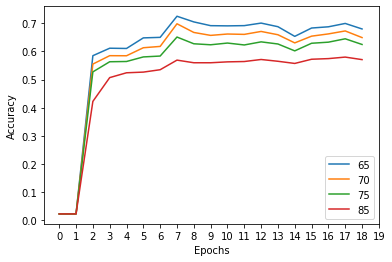

In [ ]:
sns.lineplot(y =test_accs.item()[65][1:-1], x = list(range(19)))
sns.lineplot(y = test_accs.item()[70][1:-1], x = list(range(19)))
sns.lineplot(y = test_accs.item()[75][1:-1], x = list(range(19)))
sns.lineplot(y = test_accs.item()[85][1:-1], x = list(range(19)))
plt.legend(labels = ["65", "70", "75", "85"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0,20,1.0))


In [ ]:
sns.lineplot(y =test_f1s.item()[65][1:-1], x = list(range(19)))
sns.lineplot(y = test_f1s.item()[70][1:-1], x = list(range(19)))
sns.lineplot(y = test_f1s.item()[75][1:-1], x = list(range(19)))
sns.lineplot(y = test_f1s.item()[85][1:-1], x = list(range(19)))
plt.legend(labels = ["65", "70", "75", "85"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0,20,1.0))

In [ ]:
train_losses[0]

48.266351059511564

([<matplotlib.axis.XTick at 0x7f94a4811c90>,
 <a list of 20 Text major ticklabel objects>)

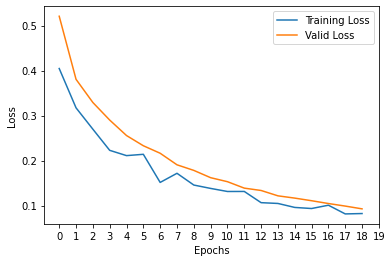

In [ ]:
sns.lineplot(y = test_losses.item()[65][2:], x = list(range(19)) )
sns.lineplot(y = train_losses[1:], x = list(range(19)))
plt.legend(labels = ["Training Loss", "Valid Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,20,1.0))

([<matplotlib.axis.XTick at 0x7f94a4339890>,
 <a list of 20 Text major ticklabel objects>)

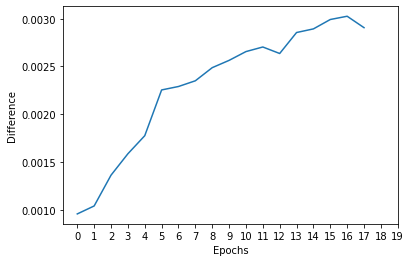

In [ ]:
rmse_fake, rmse_real = rfake, rreal

rf65 = np.asarray(rmse_fake.item()[65]).mean(axis = 1).flatten()
rr65 = np.asarray(rmse_real.item()[65]).mean(axis = 1)
rmse_diff65 = rf65 - rr65

sns.lineplot(y = rmse_diff65[3:], x = list(range(18)))
plt.xlabel("Epochs")
plt.ylabel("Difference")
plt.xticks(np.arange(0,20,1.0))

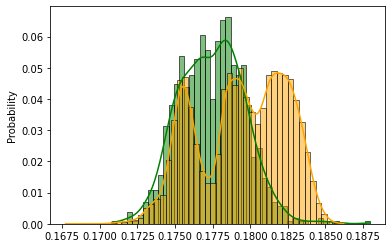

In [ ]:
flat_real = [item for sublist in rmse_real for item in sublist]
flat_fake = [item for sublist in rmse_fake for item in sublist]
sns.histplot(data=flat_real, bins = 50, stat = "probability", color = "Green", kde = True)
sns.histplot(data = flat_fake, bins = 50, stat = "probability", color = "Orange", kde = True)

In [ ]:
#Identify model divergence by checking loss, reconstructed_x, and appropriately modified learning rate to fix.
#Because of data imbalance, need to use FPR/TPR, ROC AUC or EER. These tests need probabilities, but we have been using a threshold to determine 1/0. 
# Using the array of RMSE from training, create a normal distribution with its mean and variance, and test the RMSE from validation phase 
# to determine if it came from that distribution.
# Should we train on bonafide or fake in the presence of imbalanced data

In [ ]:
#TODO:
# check input data shape and add layers. 
# Input shape: (BatchSize, Channel (1), Time (40), Frequency (200))

# Different latent size, Different layers, Different Thresholds
# Show g0mse, g1mse
#Run testing function for different thresholds every epoch

#Do:
# Dropout
# Loop over thresholds
# Show histograms
# Try: Train on fake data
# Identify why original paper trained only on real data: New kinds of fake data is constantly generated, so we need to train on real data and distinguish any other fake data.
# early stopping criteria could be accuracy. 

# Reconstruction of true data is also "fake data"